# Split pipeline

In [1]:
import polars as pl

from nebula.base import Transformer
from nebula.transformers import *
from nebula.storage import nebula_storage as ns
from nebula.pipelines.pipeline import TransformerPipeline
from nebula.pipelines.pipeline_loader import load_pipeline

In [3]:
schema = [
    StructField("c1", FloatType(), True),
    StructField("c2", StringType(), True),
    StructField("c3", StringType(), True),
]

data = [
    [0.1234, "a", "b"],
    [0.1234, "a", "b"],
    [0.1234, "a", "b"],
    [1.1234, "a", "  b"],
    [2.1234, "  a  ", "  b  "],
    [3.1234, "", ""],
    [4.1234, "   ", "   "],
    [5.1234, None, None],
    [6.1234, " ", None],
    [7.1234, "", None],
    [8.1234, "a", None],
    [9.1234, "a", ""],
    [10.1234, "   ", "b"],
    [11.1234, "a", None],
    [12.1234, None, "b"],
    [13.1234, None, "b"],
    [14.1234, None, None],
]

df_input = spark.createDataFrame(data, schema=StructType(schema)).cache()
df_input.show()

+-------+-----+-----+
|     c1|   c2|   c3|
+-------+-----+-----+
| 0.1234|    a|    b|
| 0.1234|    a|    b|
| 0.1234|    a|    b|
| 1.1234|    a|    b|
| 2.1234|  a  |  b  |
| 3.1234|     |     |
| 4.1234|     |     |
| 5.1234| null| null|
| 6.1234|     | null|
| 7.1234|     | null|
| 8.1234|    a| null|
| 9.1234|    a|     |
|10.1234|     |    b|
|11.1234|    a| null|
|12.1234| null|    b|
|13.1234| null|    b|
|14.1234| null| null|
+-------+-----+-----+



## Create a split pipeline using python
Two splits:
- The first one, `low`, with 2 transformers `RoundValues` and `Cast`
- The second one, `hi`, with 2 transformers `RoundValues` and `Cast`

The split-function `my_split_function` takes the input dataframe, divide it into two separate dataframes based on the values in the `c1` column, placing those `< 10` in one dataframe and those `>= 10` in another one. Then it returns the two dataframes in a dictionary with the keys `low` and `hi`.

In [2]:
def my_split_function(df):
    cond = F.col("c1") < 10
    return {
        "low": df.filter(cond),
        "hi": df.filter(~cond),
    }

low_values = [RoundValues(input_columns="c1"), Cast(cast={ "c1": "float" })]
hi_values = [EmptyStringToNull(columns="c2"), Cast(cast={ "c1": "float" })]


pipe = TransformerPipeline(
    {"low": low_values, "hi": hi_values},
    name="split-low-hi-values",
    split_function=my_split_function,  # provide here you custom split function
)

pipe.show_pipeline(add_transformer_params=True)

*** TransformerPipeline ***: "split-low-hi-values" (4 transformers)
SPLIT <<< hi >>>:
     - EmptyStringToNull -> PARAMS: columns="c2"
     - Cast -> PARAMS: cast={'c1': 'float'}
SPLIT <<< low >>>:
     - RoundValues -> PARAMS: input_columns="c1"
     - Cast -> PARAMS: cast={'c1': 'float'}
MERGE SPLITS:
   - <<< hi >>>
   - <<< low >>>


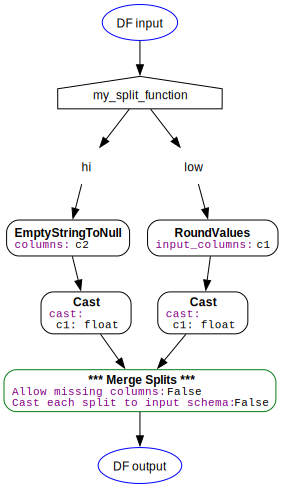

In [4]:
pipe.plot_dag(add_transformer_params=True)

In [6]:
df_out = pipe.run(df_input)
df_out.show()

2024-05-16 14:03:50,124 | pipelines.py:523 [INFO]: Running *** TransformerPipeline ***: "split-low-hi-values" (4 transformers) 
2024-05-16 14:03:50,272 | pipelines.py:556 [INFO]: Running SPLIT <<< hi >>> 
2024-05-16 14:03:50,273 | pipelines.py:283 [INFO]: Running EmptyStringToNull -> PARAMS: columns="c2" ... 
2024-05-16 14:03:50,482 | pipelines.py:297 [INFO]: Execution time for EmptyStringToNull: 0.2s 
2024-05-16 14:03:50,483 | pipelines.py:283 [INFO]: Running Cast -> PARAMS: cast={'c1': 'float'} ... 
2024-05-16 14:03:50,551 | pipelines.py:297 [INFO]: Execution time for Cast: 0.1s 
2024-05-16 14:03:50,552 | pipelines.py:556 [INFO]: Running SPLIT <<< low >>> 
2024-05-16 14:03:50,553 | pipelines.py:283 [INFO]: Running RoundValues -> PARAMS: input_columns="c1" ... 
2024-05-16 14:03:50,564 | pipelines.py:297 [INFO]: Execution time for RoundValues: 0.0s 
2024-05-16 14:03:50,564 | pipelines.py:283 [INFO]: Running Cast -> PARAMS: cast={'c1': 'float'} ... 
2024-05-16 14:03:50,576 | pipelines.p

+-------+-----+-----+
|     c1|   c2|   c3|
+-------+-----+-----+
|10.1234|     |    b|
|11.1234|    a| null|
|12.1234| null|    b|
|13.1234| null|    b|
|14.1234| null| null|
|   0.12|    a|    b|
|   0.12|    a|    b|
|   0.12|    a|    b|
|   1.12|    a|    b|
|   2.12|  a  |  b  |
|   3.12|     |     |
|   4.12|     |     |
|   5.12| null| null|
|   6.12|     | null|
|   7.12|     | null|
|   8.12|    a| null|
|   9.12|    a|     |
+-------+-----+-----+



## Create the same pipeline using yaml

In the `YAML` file, specify the split-function under the key `split_function`

The split-function must then be passed to the function `load_pipeline` as `extra_functions` value.
It can ben accomplished using a `list` (see the example) or a `dictionary` like:

`{"my_split_function": your-split-function}`

If a `list` is used, ensure that the function name aligns with the one specified in the `YAML` file.

Otherwise if a `dictionary` is used, the key must match the name in the `YAML` file, while the value can be any

In [7]:
yml_data = """
name: "split-low-hi-values"
split_function: my_split_function  # name of you split function
pipeline:
     "low":
       - transformer: RoundValues
         params:
           "input_columns": "c1"
           "precision": 1
       - transformer: Cast
         params:
           "cast": { "c1": "float" }

     "hi":
       - transformer: RoundValues
         params:
           "input_columns": "c1"
           "precision": 3
       - transformer: EmptyStringToNull
         params:
           columns: ["c2", "c3"]
"""

pipe_cfg = yaml.safe_load(yml_data)


pipe = load_pipeline(
    pipe_cfg,
    extra_functions=[my_split_function]  # provide here you custom split function as <list> or <dict>
    # equivalent to extra_functions={"my_split_function": my_split_function} as long as the function name matches the function name in YAML
)

pipe.show_pipeline(add_transformer_params=True)

*** TransformerPipeline ***: "split-low-hi-values" (4 transformers)
SPLIT <<< hi >>>:
     - RoundValues -> PARAMS: input_columns="c1", precision=3
     - EmptyStringToNull -> PARAMS: columns=['c2', 'c3']
SPLIT <<< low >>>:
     - RoundValues -> PARAMS: input_columns="c1", precision=1
     - Cast -> PARAMS: cast={'c1': 'float'}
MERGE SPLITS:
   - <<< hi >>>
   - <<< low >>>


In [8]:
pipe.run(df_input).show()

2024-05-16 14:03:51,756 | pipelines.py:523 [INFO]: Running *** TransformerPipeline ***: "split-low-hi-values" (4 transformers) 
2024-05-16 14:03:51,850 | pipelines.py:556 [INFO]: Running SPLIT <<< hi >>> 
2024-05-16 14:03:51,851 | pipelines.py:283 [INFO]: Running RoundValues -> PARAMS: input_columns="c1", precision=3 ... 
2024-05-16 14:03:51,858 | pipelines.py:297 [INFO]: Execution time for RoundValues: 0.0s 
2024-05-16 14:03:51,859 | pipelines.py:283 [INFO]: Running EmptyStringToNull -> PARAMS: columns=['c2', 'c3'] ... 
2024-05-16 14:03:51,961 | pipelines.py:297 [INFO]: Execution time for EmptyStringToNull: 0.1s 
2024-05-16 14:03:51,962 | pipelines.py:556 [INFO]: Running SPLIT <<< low >>> 
2024-05-16 14:03:51,962 | pipelines.py:283 [INFO]: Running RoundValues -> PARAMS: input_columns="c1", precision=1 ... 
2024-05-16 14:03:51,971 | pipelines.py:297 [INFO]: Execution time for RoundValues: 0.0s 
2024-05-16 14:03:51,972 | pipelines.py:283 [INFO]: Running Cast -> PARAMS: cast={'c1': 'floa

+------+-----+-----+
|    c1|   c2|   c3|
+------+-----+-----+
|10.123|     |    b|
|11.123|    a| null|
|12.123| null|    b|
|13.123| null|    b|
|14.123| null| null|
|   0.1|    a|    b|
|   0.1|    a|    b|
|   0.1|    a|    b|
|   1.1|    a|    b|
|   2.1|  a  |  b  |
|   3.1|     |     |
|   4.1|     |     |
|   5.1| null| null|
|   6.1|     | null|
|   7.1|     | null|
|   8.1|    a| null|
|   9.1|    a|     |
+------+-----+-----+



### Specific functionalities for split pipelines

- `split_apply_before_appending`:  Add transformer(s) at the end of each split before re-merging
- `split_cast_to_input_schema`:  Cast to input schema. Raise Assertion Error in case of column mismatching
- `repartition_output_to_original`:  Repartition to the input number of partitions after re-merging
- `coalesce_output_to_original`:  Repartition to the input number of partitions after re-merging

In [9]:
pipe = TransformerPipeline(
    {"low": low_values, "hi": hi_values},
    name="split-low-hi-values",
    split_function=my_split_function,
    split_apply_before_appending=[Count()],  # Add transformer(s) at the end of each split before re-merging
    split_cast_to_input_schema=True,  # Cast to input schema. Raise Assertion Error in case of column mismatching
    repartition_output_to_original=True,  # Repartition to the input number of partitions after re-merging
    coalesce_output_to_original=False,  # Repartition to the input number of partitions after re-merging
)

pipe.show_pipeline(add_transformer_params=True)

*** TransformerPipeline ***: "split-low-hi-values" (6 transformers)
SPLIT <<< hi >>>:
     - EmptyStringToNull -> PARAMS: columns="c2"
     - Cast -> PARAMS: cast={'c1': 'float'}
     - Count
SPLIT <<< low >>>:
     - RoundValues -> PARAMS: input_columns="c1"
     - Cast -> PARAMS: cast={'c1': 'float'}
     - Count
CAST EACH SPLIT TO MERGE TO THE INPUT SCHEMA AND MERGE SPLITS:
   - <<< hi >>>
   - <<< low >>>


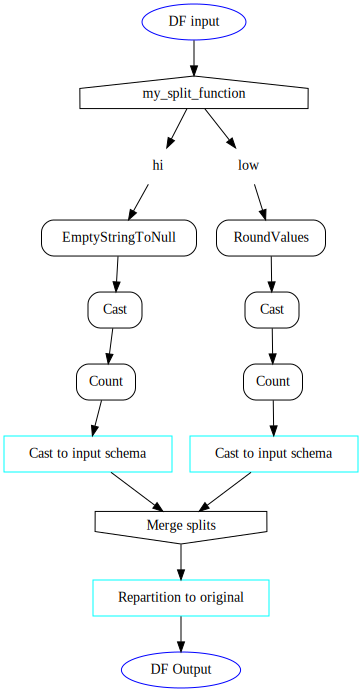

In [10]:
pipe.plot_dag()

In [11]:
pipe.run(df_input).show()

2024-05-16 14:03:52,704 | pipelines.py:523 [INFO]: Running *** TransformerPipeline ***: "split-low-hi-values" (6 transformers) 
2024-05-16 14:03:52,758 | pipelines.py:556 [INFO]: Running SPLIT <<< hi >>> 
2024-05-16 14:03:52,759 | pipelines.py:283 [INFO]: Running EmptyStringToNull -> PARAMS: columns="c2" ... 
2024-05-16 14:03:52,843 | pipelines.py:297 [INFO]: Execution time for EmptyStringToNull: 0.1s 
2024-05-16 14:03:52,843 | pipelines.py:283 [INFO]: Running Cast -> PARAMS: cast={'c1': 'float'} ... 
2024-05-16 14:03:52,854 | pipelines.py:297 [INFO]: Execution time for Cast: 0.0s 
2024-05-16 14:03:52,854 | pipelines.py:283 [INFO]: Running Count ... 
2024-05-16 14:03:53,550 | logs.py:66 [INFO]: Number of rows: 5 
2024-05-16 14:03:53,551 | pipelines.py:297 [INFO]: Execution time for Count: 0.7s 
2024-05-16 14:03:53,552 | pipelines.py:556 [INFO]: Running SPLIT <<< low >>> 
2024-05-16 14:03:53,552 | pipelines.py:283 [INFO]: Running RoundValues -> PARAMS: input_columns="c1" ... 
2024-05-16

+-------+-----+-----+
|     c1|   c2|   c3|
+-------+-----+-----+
|10.1234|     |    b|
|11.1234|    a| null|
|12.1234| null|    b|
|13.1234| null|    b|
|14.1234| null| null|
|   0.12|    a|    b|
|   0.12|    a|    b|
|   0.12|    a|    b|
|   1.12|    a|    b|
|   2.12|  a  |  b  |
|   3.12|     |     |
|   4.12|     |     |
|   5.12| null| null|
|   6.12|     | null|
|   7.12|     | null|
|   8.12|    a| null|
|   9.12|    a|     |
+-------+-----+-----+

